In [1]:
from functools import partial
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant, safe_logodds
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-03 09:18:31.630108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 09:18:31.630139: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.01)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=2, name="chisq", threshold=0.5,
                                  noise_distribution="chisq", noise_scale=s)
x, y = eg.generate_labeled(120000)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:100000, :], y[:100000]
x_val, y_val = x[100000:, :], y[100000:]

In [3]:
# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=5e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=17,
    batch_size=512,
    validation_data=(x_val, y_val)
)

Epoch 1/17


2022-05-03 09:18:34.500979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-03 09:18:34.501118: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-03 09:18:34.501205: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-03 09:18:34.501964: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


196/196 [==============================] - 2s 4ms/step - loss: 0.6471 - accuracy: 0.5234 - auc: 0.7228 - val_loss: 0.6353 - val_accuracy: 0.5274 - val_auc: 0.9302
Epoch 2/17
196/196 [==============================] - 1s 3ms/step - loss: 0.6295 - accuracy: 0.5571 - auc: 0.7655 - val_loss: 0.6150 - val_accuracy: 0.5757 - val_auc: 0.9665
Epoch 3/17
196/196 [==============================] - 1s 4ms/step - loss: 0.6135 - accuracy: 0.5897 - auc: 0.7892 - val_loss: 0.5941 - val_accuracy: 0.6302 - val_auc: 0.9837
Epoch 4/17
196/196 [==============================] - 1s 3ms/step - loss: 0.5981 - accuracy: 0.6192 - auc: 0.8028 - val_loss: 0.5722 - val_accuracy: 0.6998 - val_auc: 0.9918
Epoch 5/17
196/196 [==============================] - 1s 3ms/step - loss: 0.5805 - accuracy: 0.6555 - auc: 0.8142 - val_loss: 0.5463 - val_accuracy: 0.7784 - val_auc: 0.9951
Epoch 6/17
196/196 [==============================] - 1s 3ms/step - loss: 0.5616 - accuracy: 0.6890 - auc: 0.8202 - val_loss: 0.5164 - val_ac

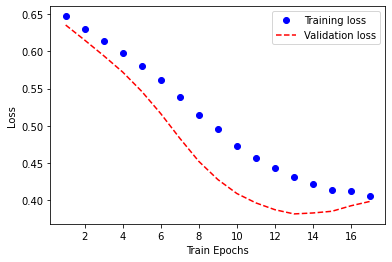

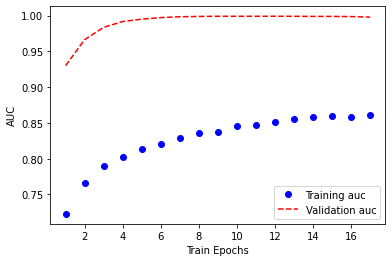

In [4]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

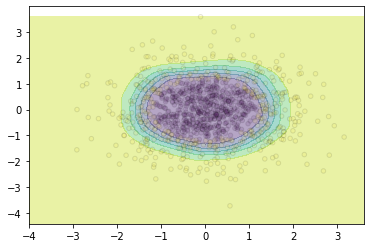

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 30)                90        
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dropout_3 (Dropout)         (None, 30)                0

In [5]:
# Plot decision regions
x_min, x_max = x_val[:, 0].min(), x_val[:, 0].max()
y_min, y_max = x_val[:, 1].min(), x_val[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
z = model.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

fig = plt.figure()
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ax.scatter(x_val[:1000, 0], x_val[:1000, 1], c=y_val[:1000], s=20, alpha=0.1, edgecolor="k")
plt.show()

model.summary()

### Tuning notes: 

* model: 0.25, 20, 0.25, 20, 0.25, 20, 0.25, 1 / batch: 512 / lr: 5e-5
* Epoch 9/17 val_loss: 0.4959 - val_accuracy: 0.9551 - val_auc: 0.9926

* model: 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1 / batch: 512 / lr: 5e-5
* Epoch 11/17 val_loss: 0.4413 - val_accuracy: 0.9657 - val_auc: 0.9978



In [13]:
# debug
n = 3
x = x_val[0:2, :]
if len(x.shape) == 1:  # if sending in a single row of x
    rows = 1
else:
    rows = x.shape[0]
xx = np.tile(x, (n, 1))
yy = model.predict(xx)
yy.shape
if len(yy.shape) == 1:  # if sending in a single row of x and drawing only one sample
    outputs = yy.shape
else:
    outputs = yy.shape[1]
preds = np.reshape(yy, (n, rows, outputs), order='c')
#preds.shape
#preds.mean(axis=0)
#preds[:,1,1]
yy.shape
#preds[:,1,1]
print(yy)
print(preds)
print(preds[:,0,0])

[[0.59661025]
 [0.88503265]
 [0.59661025]
 [0.88503265]
 [0.59661025]
 [0.88503265]]
[[[0.59661025]
  [0.88503265]]

 [[0.59661025]
  [0.88503265]]

 [[0.59661025]
  [0.88503265]]]
[0.59661025 0.59661025 0.59661025]


In [40]:
# faster mean and confidence intervals
n = 4
x = x_val[0:3, :]
if len(x.shape) == 1: 
    rows = 1
else:
    rows = x.shape[0]
xx = np.tile(x, (n,1))
yy = model.predict(xx)
y = np.reshape(yy, (rows,n), order='f')
ym = y.mean(axis=1)
print(ym)
yy

[0.63624215 0.8788816  0.6461174 ]


array([[0.63624215],
       [0.8788816 ],
       [0.6461174 ],
       [0.63624215],
       [0.8788816 ],
       [0.6461174 ],
       [0.63624215],
       [0.8788816 ],
       [0.6461174 ],
       [0.63624215],
       [0.8788816 ],
       [0.6461174 ]], dtype=float32)

In [38]:
yy = np.array([[0.2, 0.2, 0.2, 0.4], 
               [0.1, 0.1, 0.1, 0.7], 
               
               [0.2, 0.2, 0.2, 0.4], 
               [0.1, 0.1, 0.1, 0.7], 
               
               [0.2, 0.2, 0.2, 0.4], 
               [0.1, 0.1, 0.1, 0.7]])
np.reshape(yy, (3,2,4)) # n, rows, dims

array([[[0.2, 0.2, 0.2, 0.4],
        [0.1, 0.1, 0.1, 0.7]],

       [[0.2, 0.2, 0.2, 0.4],
        [0.1, 0.1, 0.1, 0.7]],

       [[0.2, 0.2, 0.2, 0.4],
        [0.1, 0.1, 0.1, 0.7]]])

In [19]:
x_min, x_max = 0., 0.1
y_min, y_max = 0., 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
z = model.predict(np.c_[xx.ravel(), yy.ravel()])

In [20]:
xx, yy, z

(array([[0.]]), array([[0.]]), array([[0.251633]], dtype=float32))